# **Higgs Boson Detector: Replicating Neural Network Architecture in TensorFlow**

# **Objective**

In the study of particle physics, proving the existence of a Higgs boson particle provides a potential answer to why particles are attributed with mass under the framework of the Standard Model that explains the forces of nature. Monte Carlo simulations were used to present data for the classification of Higgs Boson particle signals. 

This study aims to replicate the neural network design presented in the paper published in 2014 ["Searching for exotic particles in high-energy physics with deep learning"](https://arxiv.org/pdf/1402.4735.pdf) under the TensorFlow framework as well as consider potential improvements over the architecture provided. The neural network is tasked with discriminating Higgs boson particles from background noise.



In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, Dropout, Activation

print(tf.__version__)

2.2.0


In [ ]:
#!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [ ]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

# **Data Description**

Data for the Benchmark Case for Higgs Bosons (HIGGS), known as the [HIGGS Data Set](https://archive.ics.uci.edu/ml/datasets/HIGGS), is available at the UCI Machine Learning Repository. It consists of 11 million rows produced by Monte Carlo simulations. 

*   Column 1 denotes the label for the classification problem: 1 for a signal process that produces Higgs bosons and 0 for a background process that does not.
*   Columns 2-22 are low-level features measured by particle detectors. For details, please refer to the attribute information on the dataset description landing page or the original paper.
  * **low-level features**: lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag
*   Columns 23-29 are high-level features based on the low-level ones, developed for discrimination purposes.
  *  **high-level features**: m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb

Note that the paper references two datasets for two different classification tasks: a benchmark case for Higgs bosons and a benchmark case for supersymmetry particles. Only the former is addressed in this discussion.


In [ ]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz')
FEATURES = 28
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

2816409600/2816407858 [==============================] - 132s 0us/step


In [ ]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

In [ ]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

In [ ]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


In [ ]:
N_VALIDATION = int(1e3)
N_TRAIN = int(2.6e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 100
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

# **Replica Neural Network**

In [ ]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [ ]:
def compile_and_fit(model, name, optimizer=None, max_epochs=1000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.AUC(name='AUC'),tf.keras.losses.BinaryCrossentropy(from_logits=True, name='binary_crossentropy')])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

In [ ]:
replica = tf.keras.Sequential([
    layers.Dense(300, activation='tanh', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(300, activation='tanh', input_shape=(FEATURES,)),
    layers.Dense(300, activation='tanh', input_shape=(FEATURES,)),
    layers.Dense(300, activation='tanh', input_shape=(FEATURES,)),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
histories = {}
opt = SGD(lr=0.05, momentum=0.99, decay=1e-5)
histories['replica'] = compile_and_fit(replica, 'replica', optimizer=opt)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 300)               8700      
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_12 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_13 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 301       
Total params: 279,901
Trainable params: 279,901
Non-trainable params: 0
________________________________________________

In [ ]:
# Code from https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network
from math import cos, sin, atan

class Neuron():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def draw(self, neuron_radius):
        circle = plt.Circle((self.x, self.y), radius=neuron_radius, fill=False)
        plt.gca().add_patch(circle)


class Layer():
    def __init__(self, network, number_of_neurons, number_of_neurons_in_widest_layer):
        self.vertical_distance_between_layers = 6
        self.horizontal_distance_between_neurons = 2
        self.neuron_radius = 0.5
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.previous_layer = self.__get_previous_layer(network)
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.__intialise_neurons(number_of_neurons)

    def __intialise_neurons(self, number_of_neurons):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in range(number_of_neurons):
            neuron = Neuron(x, self.y)
            neurons.append(neuron)
            x += self.horizontal_distance_between_neurons
        return neurons

    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return self.horizontal_distance_between_neurons * (self.number_of_neurons_in_widest_layer - number_of_neurons) / 2

    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + self.vertical_distance_between_layers
        else:
            return 0

    def __get_previous_layer(self, network):
        if len(network.layers) > 0:
            return network.layers[-1]
        else:
            return None

    def __line_between_two_neurons(self, neuron1, neuron2):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        x_adjustment = self.neuron_radius * sin(angle)
        y_adjustment = self.neuron_radius * cos(angle)
        line = plt.Line2D((neuron1.x - x_adjustment, neuron2.x + x_adjustment), (neuron1.y - y_adjustment, neuron2.y + y_adjustment))
        plt.gca().add_line(line)

    def draw(self, layerType=0):
        for neuron in self.neurons:
            neuron.draw( self.neuron_radius )
            if self.previous_layer:
                for previous_layer_neuron in self.previous_layer.neurons:
                    self.__line_between_two_neurons(neuron, previous_layer_neuron)
        # write Text
        x_text = self.number_of_neurons_in_widest_layer * self.horizontal_distance_between_neurons
        if layerType == 0:
            plt.text(x_text, self.y, 'Input Layer: 28 features', fontsize = 12)
        elif layerType == -1:
            plt.text(x_text, self.y, 'Output Layer', fontsize = 12)
        else:
            plt.text(x_text, self.y, 'Hidden Layer '+str(layerType)+': 300 neurons', fontsize = 12)

class NeuralNetwork():
    def __init__(self, number_of_neurons_in_widest_layer):
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.layers = []
        self.layertype = 0

    def add_layer(self, number_of_neurons ):
        layer = Layer(self, number_of_neurons, self.number_of_neurons_in_widest_layer)
        self.layers.append(layer)

    def draw(self):
        plt.figure()
        for i in range( len(self.layers) ):
            layer = self.layers[i]
            if i == len(self.layers)-1:
                i = -1
            layer.draw( i )
        plt.axis('scaled')
        plt.axis('off')
        plt.title('Replica Architecture', fontsize=15)
        caption = 'Nodes pictured reduced for visual display purposes'
        plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=8)
        plt.show()

class DrawNN():
    def __init__( self, neural_network ):
        self.neural_network = neural_network

    def draw( self ):
        widest_layer = max( self.neural_network )
        network = NeuralNetwork( widest_layer )
        for l in self.neural_network:
            network.add_layer(l)
        network.draw()

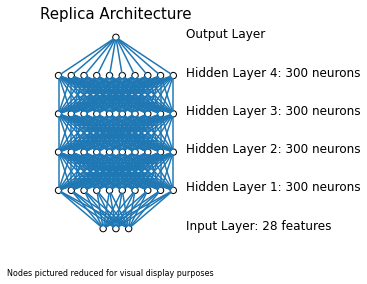

Figure 1: Replica Higgs Boson Detection Deep Learning Architecture


In [ ]:
# Correct layer argument should be [28,300,300,300,300,1]
network = DrawNN( [3,10,10,10,10,1] )
network.draw()
print('Figure 1: Replica Higgs Boson Detection Deep Learning Architecture')

A highly simplified diagram of the paper's original architecture is shown above in Figure 1 to give some intuition to what is occurring. Creating an image where all hidden layers show 300 neurons and the connections between them would likely make it difficult to discern any nodes and edges at all. Further insight into the details of each layer, such as activation functions and weights, is discussed in the next section.

# **Discussion**



*   **Activation functions**: All hidden units used the *tanh* activation function. Since the paper's publication in 2014, the Rectified Linear Unit (ReLU) has become more commonly used due to addressing issues of sparsity and vanishing gradients, both of which cause optimization problems for tanh.
* **Optimizer**: The replica network uses a stochastic gradient descent (SGD) optimizer. Since 2014, SGD algorithms have been extended with the Adam algorithm that has the advantages of an adaptive gradient algorithm (AdaGrad) and root mean square propagation (RMSProp). The Adam optimizer similarly alleviates issues of sparse gradients on noisy problems. 
*   **Neurons**: 100, 200, 300, and 500 were hyperparameter options, with *300* neurons per hidden layer the actual number used. It is common to see the shape of the network narrow with depth (intuitively forcing the network to learn lower-level features and filter noise at subsequent layers), but current research does not support the notion this is required; it is equally valid from a performance standpoint to have the same number of neurons at each hidden layer. Some rule-of-thumb methods that bound the number of hidden neurons per layer using the input and output layer sizes were likely overridden by the sheer amount of training data and anticipated complexity of the problem.
*   **Weights**: 
  *   First layer: 0.1
  *   Hidden layers: 0.05
  *   Output layer: 0.001

  Initial weights were given by a normal distribution with standard deviations given by the above bullets. While randomizing initial weights is typical, predefining the variance based on the location in the architecture does not seem to be standard practice.
*   **Decay rates**: 0 and 10<sup>-5</sup> were hyperparameter options, with 10<sup>-5</sup> ultimately chosen. The step-based decay value used is typical. Aother option aside from setting the learning rate schedule is to use an adaptive learning rate.
*   **Batch sizes**: Mini-batches of 100 were used for estimating gradient descent. Power of 2 values (32, 64, 128, 256, etc) that match memory hardware are more commonly used.
*   **Initial learning rate**: 0.01 and 0.05 were hyperparameter options, with *0.05* actually used. This value decayed by a factor of 1.0000002 after each batch until hitting a 10<sup>-6</sup> minimum. The initial rates are typical among default values, though a grid search for the initial rate commonly extends from 10<sup>-1</sup> to 10<sup>-6.
*   **Layers**: 2, 3, 4, 5, and 6 were hyperparameter options, with a depth of *5* ultimately chosen. Note that this translates to four hidden layers and one output layer; the input layer is not counted in defining depth. Current empirical research shows one hidden layer is often sufficient, but it's possible that the complexity of this problem warrants more; Supplementary Table 3: Study of network size and depth in the original paper demonstrates significant AUC increases by increasing the number of hidden layers.
*   **Dropout**: *0.5* in the first hidden layer only. This rate is still commonly used for hidden layers at the present time, though varying it by some value between [0.5, 0.9] can also be done. Some papers apply dropout to all hidden layers. Another potential practice is applying dropout on the input layer (though at a larger rate, usually 0.8).
*   **Epochs**: Training time ranged from *200-1000* epochs, with early stopping defined when decrease in minimum error on the validation set plateaued. Stopping at a convergence point like this to prevent overfitting is currently standard practice.
*   **Momentum**: Increased from *0.9 to 0.99* over the first 200 epochs. This type of progression is still typically used.


It's worth noting that the context of this problem allowed for a large number of data points--subsets were used from 2.6 million training examples, 100,000 validation examples, and 500,000 test examples. The average AUC achieved was 0.885. While domain-specific literature could not be found that speaks to comparable AUC values, this classifier's performance would likely be considered good; despite the apparent complexity of the network, there is not substantial evidence of overfitting. Usage of dropout in the top most hidden layer and smaller weights in the later layers likely helped prevent overfitting in the original paper. To speed up training time, our replica network is only trained on 26,000 examples and validated on 1,000 examples.

Trial-and-error via grid search was used to select the best-performing set of parameters. A similar approach would likely be employed today. Given sufficient time and computational constraints, the searchable parameters could be expanded as described above.

The deep learning architecture in the paper employs a linearly increasing momentrum term for the stochastic gradient descent (SGD) optimizer over the first 200 epochs from 0.9 to 0.99. In contrast, the replica neural network presented is parameterized with a constant momentum term of 0.99 over all epochs.

Since the paper's publication, many different types of neural networks have become more well-researched and popularized for varying use cases, including convolutional neural networks (CNN) and recurrent architectures like long short-term memory (LSTM). Combing the research for instances where emergent architectures have shown promise in this type of application could provide alternative methods that potentially involve fewer layers and faster training times without sacrificing performance.

# **Comparison**

The training and validation loss curves from our replica neural network highly overlap and provide strong evidence against overfitting, suggesting that it will generalize well to new data. The loss function used was binary_crossentropy since the problem is a binary classification: Higgs Boson signal against background signal noise.

The curves begin to level off following roughly 700 training epochs as shown in Figure 2 below. The replica network completed training around 900 epochs with a early termination if there is no improvement after 200 epochs.

Figure 2: Training and Validation Loss Curves


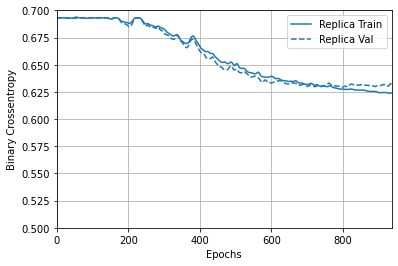

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(histories)
plt.ylim([0.5, 0.7])
print("Figure 2: Training and Validation Loss Curves")


The original paper describes use of Receiver Operating Characteristic (ROC) curves to show classifier performance, with the area under the ROC curve (AUC) as the main comparison metric. This is demonstrated in the paper's Table I: Performance for Higgs benchmark, which gives AUC values for boosted decision trees (BDT), shallow neural networks (NN), and deep neural networks (DN) on the low-level, high-level, and complete feature sets. 

AUC is a useful single-value comparison metric that is well-defined and unambiguous in its calculation, indicating overall tradeoff of a model's true positive rate against its false positive rate across various discrimination thresholds. Within the context of particle physics, ROC curves are often described in terms of background rejection (false positive rate) against signal efficiency (true positive rate). 

Notice that within the paper itself, comparisons are made across different learners, namely BDT and neural nets. This illustrates how the AUC can be used quantitatively to compare results of different techniques. Thus, with AUC we have a convenient method to compare our duplication of the original architecture (or use of any other learner). Specifically, we would likely compare against the DN on the complete dataset, which yielded the highest AUC at 0.885 +/- 0.002 over five instances.

Figure 3: Train and Validation AUC Curves


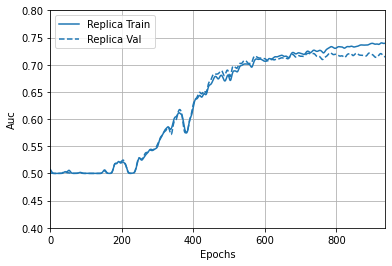

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'AUC', smoothing_std=10)
plotter.plot(histories)
plt.ylim([0.4, 0.8])
print("Figure 3: Train and Validation AUC Curves")

The AUC curves for our replica network architecture are shown above in Figure 3. On the validation data, the network yielded an AUC around 0.71 which underperforms compared to the paper's deep learning architecture (DN). This may be attributed to the smaller training and validation examples used for a shorter training time. The poor performance suggests that the linearly increasing momentum component for SGD may boost accuracy. 

However, this replica network presented has also yet to be optimized through hyperparameter tuning and modern algorithms. As previously noted, an Adam optimizer and the ReLU activation function may be more appropriate for this specific problem since they can help alleviate issues with sparse, vanishing gradients on noisy data such as particle signal collisions.

Weight regularization also offers further improvement to this network architecture to constrain the complexity and dimensionality of a network. The distribution of parameter values is regularized by forcing parameter weights to be small. A L1 regularization adds a cost proportional to the absolute value of weight coefficients to the network's loss function. A L2 regularization adds a cost proportional to the squared value of weight coefficients. 

A L1 regularization tends to produce a sparse model since weights are pushed to exactly 0, while a L2 regularization penalizes weight parameters by associating large weights to a larger penalty without producing a sparse model.

# **Conclusion**
In our exploration of the Higgs classifier deep learning architecture in tensorflow, we found the paper provided a serviceable approach that produced decent results with no overfitting issues (validation AUC ~0.71). This was a large and deep network with several large hidden layers, but it was not optimized and much hyper-parameter tuning was missing.

Key changes based on today's practices would be to address issues with the vanishing gradient, such as using a Rectified Linear Unit as an activation function instead of tanh. Another option is to use an Adam optimizer to ignore gradient entirely, and instead establish a per-parameter learning rate. Given that this domain contains a lot of noisy data, RMSProp would probably be the best option for an Adam optimizer.

Overall, the main differences highlighted between neural network practices over the last 6 years are around the use of learning methods and model optimization. Many modern networks steer clear of single points of failure like sparse models and vanishing gradient, to which this model seems to fall victim. With some updates this could be a powerful model in particle physics.

